# Exercises

We have four exercises in this section:
1. Rewrite the CART method to the Gini index.
2. Use pydot do draw the tree for C4.5 example.
3. Implement the reduced error pruning (REP).
4. Plot OC1 tree, but instead of elements id, print the feature id it was split by.

In [1]:
import math
import numpy as np
import pydot
import copy
from pydot import Dot

## Exercise 2: Use pydot do draw the tree for C4.5 example

Fill the code below.

In [2]:
%store -r split_history_c45

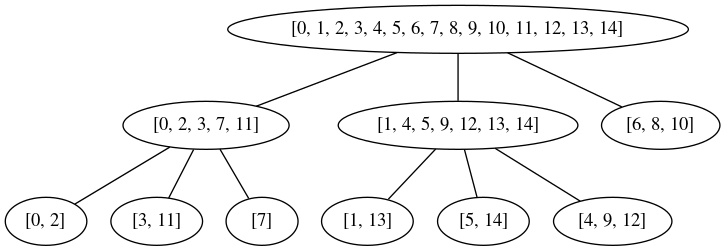

In [3]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

from IPython.display import Image
Image(filename='c45_tree.png') 

## Exercise 3: Implement the reduced error pruning (REP)

Implement the REP method and use it on the tree created with OC1 classifier. You need to the following:
- implement the accuracy function,
- manipulate the data to go through the path of the tree.

The REP method checkes the accuracy at each node and prune the node if the split gives a lower accuracy. Check the node as ``validated`` when checked and ``completed`` when pruned. When pruned set also the leafs to ``None``.

In [4]:
import math
import numpy as np
import copy

test_labels = [1,1,-1,-1,1,1,1,-1]
test_data_set = [[1,1,2,2],[3,2,1,2],[2,3,1,2],
                [2,2,1,2],[1,3,2,2],[2,1,1,2],
                [3,1,2,1],[2,1,2,2]]

labels = [1,1,-1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1]
data_set = [[1,1,2,2],[2,1,2,2],[1,1,1,2],[1,2,1,2],[2,3,2,2],
                [2,2,1,2],[3,2,2,1],[1,3,2,2],[3,3,2,1],[2,3,1,2],
                [3,1,1,1],[1,2,1,1],[2,3,1,1],[2,1,1,2],[2,2,1,1]]


In [5]:
class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.split_value = None
        self.labels = labels
        self.completed = False
        self.ids = ids
        self.validated = False

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_split_value(self, value):
        self.split_value = value

    def get_split_value(self):
        return self.split_value

    def set_validated(self):
        self.validated = True

    def is_validated(self):
        return self.validated

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

In [6]:
labels_count = len(np.unique(labels))
ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root

In [7]:
def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node


def find_leaf_not_completed(root):
    return is_leaf_completed(root)


def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()


def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count


def calculate_omega(elements, column_id):
    t_l = count_number_of_elements(elements[0], column_id)
    t_r = count_number_of_elements(elements[1], column_id)
    p_l = t_l * 1.0 / len(current_node.elements) * 1.0
    p_r = t_r * 1.0 / len(current_node.elements) * 1.0

    sum_p = 0
    labels = get_unique_labels(current_node.labels)
    for i in range(labels_count):
        p_class_t_l = (get_number_of_labels_for_value(elements[0], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[0], column_id) * 1.0)
        p_class_t_r = (get_number_of_labels_for_value(elements[1], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[1], column_id) * 1.0)
        sum_p = sum_p + math.fabs(p_class_t_l - p_class_t_r)
    return 2.0 * p_l * p_r * sum_p


def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False


def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_split_value(value)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    return current_node, split_history

def get_current_node():
    return find_leaf_not_completed()

In [8]:
def build(root_node):    
    current_node = root_node
    stop_criterion = False
    split_history = []
    
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_omega(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id],
                                                 max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

In [9]:
def plot_tree(split_history):
    tree = Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('split_history_cart_tree.png', format='png')
    

In [10]:
cart_tree, split_history_cart = build(current_node)
plot_tree(split_history_cart)

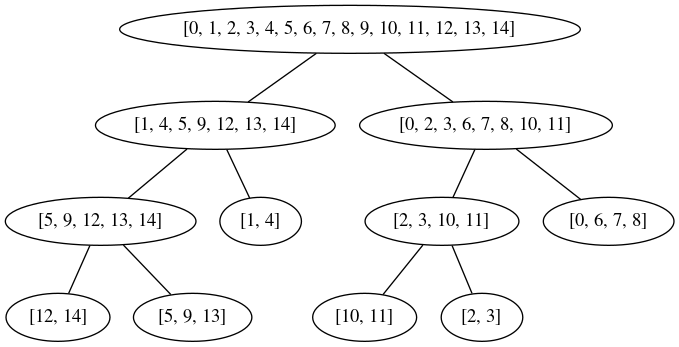

In [11]:
from IPython.display import Image
Image(filename='split_history_cart_tree.png') 

In [12]:
def my_print(cart_tree):
    print(cart_tree, 
      cart_tree.get_labels(),
      cart_tree.get_ids(),
      cart_tree.get_elements(),
      cart_tree.get_split(),
      cart_tree.get_split_value(),sep='\n')
    return

In [13]:
def data_propagation(cart_tree, test_data_set):
    split_feature = cart_tree.get_split()  # = 0
    split_value = cart_tree.get_split_value()  # = 2
    left  = []
    right = []
    for i, sample in enumerate(test_data_set):
        if sample[split_feature] >= split_value:
            left.append(i)
        else:
            right.append(i)
    
    return right, left

In [14]:
def path(cart_tree, point):
    current_node = cart_tree 
    while current_node.get_R() != None or current_node.get_L() != None:
        split_feature = current_node.get_split()  
        split_value = current_node.get_split_value()  
 
        if point[split_feature] >= split_value:
            current_node = current_node.get_L()
        else:
            current_node = current_node.get_R()
        prediction = np.sign(np.average(current_node.get_labels() ))
        if prediction == 0:
            return 1
    return prediction

def tree_predict(cart_tree, data_set):
    predictions = []
    for sample in data_set:
        predictions.append(path(cart_tree,sample))
    return(predictions)

def get_accuracy(cart_tree, test_data_set, test_labels):  
    predictions = tree_predict(cart_tree, test_data_set)   
    accuracy = 0
    for i in range( len(predictions)):
        if predictions[i] == test_labels[i]:
            accuracy = accuracy +1       
    return (accuracy / len(test_labels))

def are_there_children(node):
    return node.get_R() != None

#Proper level definition
def get_next_level(node_list):
  
    # Initialize empty list of nodes in the next level
    new_node_list = []
    
    # If we get single node - convert it to a list of one node
    if type(node_list) is not list:
        node_list = [node_list]
        
    # Construct new level out of child nodes
    # If right child is None - don't append anything
    # If left child is None - don't append anything
    for node in node_list:
        if node.get_R() != None:
            new_node_list.append(node.get_R())
        if node.get_L() != None:
            new_node_list.append(node.get_L())
    return new_node_list

# List of tree levels
def level_list(tree):

    # Starting at the root of the tree as a single node in level 0
    all_levels = [[cart_tree]]
    
    # Loop with empty STOP condition
    while(True):
        # Construct a list for the next level
        new_levels = get_next_level(all_levels[-1])
        
        # If the new level list is empty - break the loop, we reached the absolute leaf level
        if(len(new_levels) == 0):
            break          
        # If not empty - we append it, as it is the next level in our tree.
        else:
            all_levels.append(new_levels)
    return all_levels

# def validate_rep(cart_tree, test_data_set, test_labels):

#     best_tree = copy.deepcopy(cart_tree)
#     best_accuracy = get_accuracy(best_tree, test_data_set, test_labels)
#     print("BEST ACCURACY:", best_accuracy)
#     tmp_tree =  copy.deepcopy(cart_tree)
    
#     level = [tmp_tree.get_R(),tmp_tree.get_L()]
    
    
#     leaf = level[1]
#     if(level[1].get_L() != None and level[1].get_R()!= None):
#         leaf.set_L(None)
#         leaf.set_R(None)
#         a = get_accuracy(tmp_tree, test_data_set, test_labels)
#         print("without  left node",a)
        
#     #1
#     leaf = level[0]
#     if(level[0].get_L() != None and level[0].get_R()!= None):
#         leaf.set_L(None)
#         leaf.set_R(None)
#         a = get_accuracy(tmp_tree, test_data_set, test_labels)
#         print("without  right node",a)
        
    
     
#     while level != None:
#         for leaf in level:           
#             accuracy = get_accuracy(leaf,test_data_set, test_labels)
#             print(accuracy)
            
#             if accuracy < old_accuracy:
#                 print("To be pruned:")
#                 print(leaf.elements)
#                 print(leaf.labels)
#                 leaf.set_completed()
#             else:
#                 old_accuracy = accuracy            
#         level = get_curent_level(level)

In [15]:
def tree_pruning(cart_tree, test_data_set, test_labels):
    #Get all levels of the tree and calculate initial accuracy
    all_levels = level_list(cart_tree)
    best_accuracy = get_accuracy(cart_tree, test_data_set, test_labels)
    print("Initial accuracy:",best_accuracy,"\n")
    
    #Iterate over the levels
    for i, level in enumerate(all_levels[1:-1]):
        print("Level",i + 1)
        
        #Iterate over leafs in the level
        for j, leaf in enumerate(level):
            print("\tLeaf",j)
            
            #Check whether there are children - if there are, it's a leaf!
            if are_there_children(leaf):
                
                #Save current children
                tmpR = leaf.get_R()
                tmpL = leaf.get_L()
                
                #Take the children away
                leaf.set_R(None)
                leaf.set_L(None)
                
                #Check the current accuracy!
                current_accuracy = get_accuracy(cart_tree, test_data_set, test_labels)
                print("\t\tAccuracy after pruning:",
                      current_accuracy,
                     "\n")
                if(current_accuracy >= best_accuracy):
                    best_accuracy = current_accuracy
                    print("\t\tPRUNE IT!\n")
                    
                #Give the children back
                leaf.set_R(tmpR)
                leaf.set_L(tmpL)
            else:
                print("\t\tIt's a leaf!\n")
    print("Level 3: Nothing to consider, just leaves here")

In [16]:
tree_pruning(cart_tree, test_data_set, test_labels)

Initial accuracy: 0.625 

Level 1
	Leaf 0
		Accuracy after pruning: 0.625 

		PRUNE IT!

	Leaf 1
		Accuracy after pruning: 0.625 

		PRUNE IT!

Level 2
	Leaf 0
		It's a leaf!

	Leaf 1
		Accuracy after pruning: 0.625 

		PRUNE IT!

	Leaf 2
		It's a leaf!

	Leaf 3
		Accuracy after pruning: 0.625 

		PRUNE IT!

Level 3: Nothing to consider, just leaves here


## Exercise 3: Implement the reduced error pruning (REP)

Implement the REP method and use it on the tree created with OC1 classifier. You need to the following:
- implement the accuracy function,
- manipulate the data to go through the path of the tree.

The REP method checkes the accuracy at each node and prune the node if the split gives a lower accuracy. Check the node as ``validated`` when checked and ``completed`` when pruned. When pruned set also the leafs to ``None``.